# Task

With AI-modelling and Data Science there is plenty of opportunity to improve processes or suggest improved ways of doing things. When doing so it is often very smart and efficient (time is a scarce resource) to create a POC (Proof of Concept) which basically is a small demo checking wether it is worthwile going further with something. It is also something concrete which facilitates discussions, do not underestimate the power of that. 

In this example, you are working in a company that sells houses and they have a "manual" process of setting prices by humans. You as a Data Scientist can make this process better by using Machine Learning. Your task is to create a POC that you will present to your team colleagues and use as a source of discussion of wether or not you should continue with more detailed modelling. 

Two quotes to facilitate your reflection on the value of creating a PoC: 

"*Premature optimization is the root of all evil*". 

"*Fail fast*".


**More specifially, do the following:**
1. A short EDA (Exploratory Data Analysis) of the housing data set.
2. Drop the column `ocean_proximity`, then you only have numeric columns which will simplify your analysis. Remember, this is a POC! 
3. You have missing values in your data (not sure you do but you can assume so). Handle this with `SimpleImputer(strategy="median")`. (Check the fantastic Scikit-learn documentation for details.) Notice, the `SimpleImputer` should only be used for transformation on the validation and test data, not fitting.
4. Split your data into `X` and `y`, and then into train, validation and test sets. 
5. Create one `LinearRegression` model and one `Lasso` model. For the `Lasso` model, use `GridSearchCV` to optimize $\alpha$ values. Choose yourself which $\alpha$ values to evaluate.
Use RMSE as a metric to decide which model to choose. 

6. Which model is best on the validation data? 

7. Evaluate your chosen model on the test set using the root mean squared error (RMSE) as the metric. 
What are your conclusions? Note: to be 100% sure, you should re-fit your chosen model on the combination of train+val data. 

8. Do a short presentation (~ 2-5 min) on your POC that you present to your colleagues (no need to prepare anything particular, just talk from the code). Think of:
- What do you want to highlight/present?
- What is your conclusion?
- What could be the next step? Is the POC convincing enough or is it not worthwile continuing? Do we need to dig deeper into this before taking some decisions?

------------
Bonus question for those who have time and are ambitious: Redo everything above (copy your code) but in step 2, include the column `ocean_proximity` which is a categorical column. 

# Code

The goal is to predict house prices (median_house_value). The prediction is more important than understanding relationships between variables. 

It is a supervised problem, and more specifically a regression problem. 

In [90]:
import numpy as np                        
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [91]:
# Read dataset housing in same folder 
housing = pd.read_csv(r'housing.csv')

## EDA

In [92]:
print(housing.head())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


In [93]:
print(housing.info())
# 20 640 observations in the dataset. 10 variables. 
# 207 null-values for total_bedrooms
# All variables are numerical except ocean_proximity

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


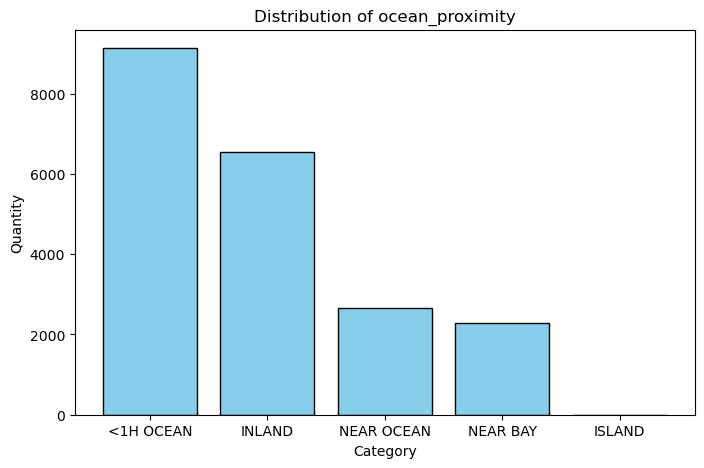

In [95]:
print(housing["ocean_proximity"].unique())
print("")
value_counts = housing["ocean_proximity"].value_counts()
print(value_counts)

plt.figure(figsize=(8, 5))
plt.bar(value_counts.index, value_counts.values, color="skyblue", edgecolor="black")
plt.xlabel("Category")
plt.ylabel("Quantity")
plt.title("Distribution of ocean_proximity")
plt.show()


# ocean_proximity is a categorical variable
# The category Island have very few observations. The distribution in general is imbalanced. 

In [96]:
print(housing.describe())

          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.00000

In [97]:
print(housing.isnull().sum())  
# total_bedrooms have 207 null-values. 
# Missing values need to be handled. Possible solutions: Delete rows, imputation (mean, median, advanced methods e.g. PMM). 
# Per instructions, median values are to be used. Handled later. 

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


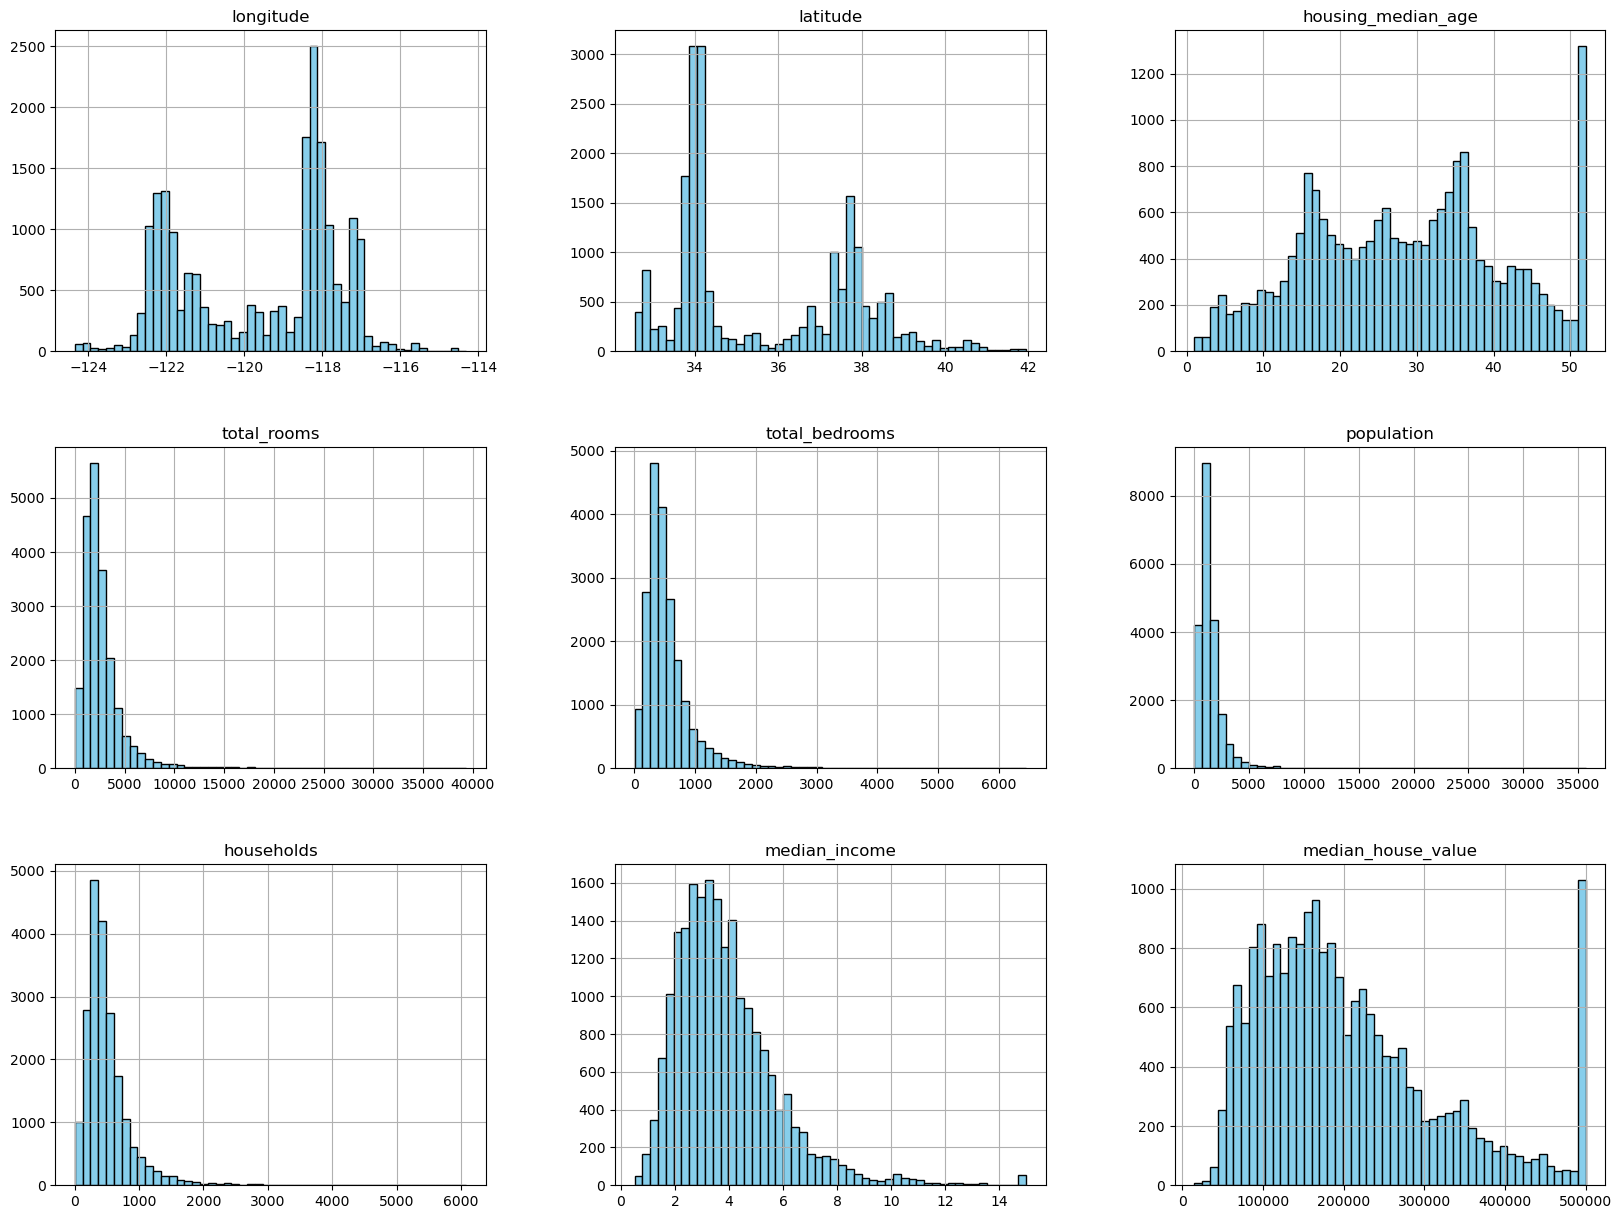

In [98]:
housing.hist(bins=50, figsize=(20,15), color="skyblue", edgecolor="black") 
plt.show()

# median_income is scaled and capped. Approximately tens of thousands of dollars. 0.499900-15.000100.  
# housing_median_age is capped at 52. 
# median_house_value is capped. 14 999-500 001 dollars. 
# Attributes are tail-heavy. 
# Attributes have different scales. 

## Preparing data

In [99]:
# Delete ocean_proximity column
housing.drop(columns=["ocean_proximity"], inplace=True)
print(housing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None


In [110]:
# Split the data into `X` and `y`, and then into train, validation and test sets.

X = housing.drop(columns=["median_house_value"])
y = housing["median_house_value"]

# Train (60%) Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Validation (20%) Test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [101]:
# Null-values in total_bedrooms. Per instructions, median values are to be used.

imputer = SimpleImputer(strategy="median")

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

print(X_train.isnull().sum().sum())
print(X_val.isnull().sum().sum())
print(X_test.isnull().sum().sum())

0
0
0


In [102]:
# Standardization
# Ensure all features are on the same scale 
# Crucial for Lasso, beneficial for Linear regression

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# The difference between doing and not doing the standarization was not that big. Some improvement in the Lasso model. 

## Models

In [103]:
# Linear Regression 

linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)

y_pred_linreg = linreg_model.predict(X_val)

rmse_linreg = np.sqrt(mean_squared_error(y_val, y_pred_linreg))
print(f"RMSE Linear Regression: {rmse_linreg}")

RMSE Linear Regression: 71014.61817293166


In [104]:
# Lasso

lasso = Lasso()

param_grid = {'alpha': [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]}
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']

lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X_train, y_train)

y_pred_lasso = lasso_model.predict(X_val)

rmse_lasso = np.sqrt(mean_squared_error(y_val, y_pred_lasso))
print(f"RMSE Lasso Regression: {rmse_lasso}")

RMSE Lasso Regression: 70994.35576056238


## Evaluation

In [105]:
# Train + Validation
X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))

# Lasso
lasso_model_final = Lasso(alpha=best_alpha)
lasso_model_final.fit(X_train_val, y_train_val)

y_test_pred = lasso_model_final.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Final RMSE Lasso Regression: {rmse_test:.4f}")

Final RMSE Lasso Regression: 69946.4100


In [107]:
print(f"Standard deviation of y_test: {y_test.std():.4f}")
# RMSE is lower than the standard deviation, which is good. 

print(f"Mean of y_test: {y_test.mean():.4f}")
print(f"RMSE / Mean: {rmse_test / y_test.mean():.2%}")
# The procentage is quit high which indicates that the model is not that great. 

Standard deviation of y_test: 117109.2642
Mean of y_test: 209806.9290
RMSE / Mean: 33.34%


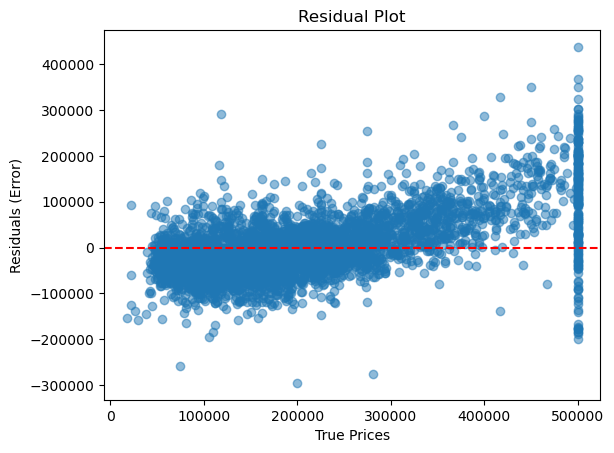

In [108]:
residuals = y_test - y_test_pred

plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("True Prices")
plt.ylabel("Residuals (Error)")
plt.title("Residual Plot")
plt.show()

# Det verkar som att det finns en systematisk underskattning av de högre huspriserna. 
# Detta kan bero på att vi har färre datapunkter för dyrare hus, att det finns en övre gräns på huspriser som gjort att modellen inte kunnat 
# lära sig tillräckligt bra eller att det finns icke-linjära mönster i datan.  

## Conclusions

- What do you want to highlight/present?
- What is your conclusion?
- What could be the next step? Is the POC convincing enough or is it not worthwile continuing? Do we need to dig deeper into this before taking some decisions?


Prediktionerna som görs är inte tillräckligt bra och det bör ses över om dessa kan förbättras. 
Residualplotten visar att det finns systematiska fel i prediktionerna. 

Jag anser att det behöver göras lite mer efterforskningar för att se om modellen kan förbättras och om det således är en bra idé att ersätta den manuella prissättningen. Eventuellt kan den användas som ett verktyg för kunder att kunna göra en snabb prediktering online? 

Nästa steg: 
- Undersök linjäritet mellan responsvariabel och oberoende variabler. 
- Se över om det finns några outliers och om de behöver hanteras. 
- Analysera korrelation mellan variabler. 
- Analysera hur påverkan från att gränser för variabler satts, är det möjligt att ta bort dessa? Finns data? Se över datan generellt. 
- Variablerna longitud och latitud skiljer sig från övriga varibler i och med att de representerar geografisk plats snarare än en egenskap som direkt påverkar priset. Men visst borde platsen spela roll på priset såklart. Kanske kan dessa hanteras på något annat sätt, skapa ny variabel baserad på avstånd från havet? Det är möjligt att klustra geografiska platser? Alltså skapa mer intuitiv variabel/skapa geografiskt mönster som modellen kan förstå bättre. 


- Testa att transformera variabler om avvieklser hittas som behöver hanteras och se om modellen kan förbättras. 
- Testa andra modeller, kanske någon som kan fånga mer komplexa mönster? 